# Visão Computacional
## Projeto 5 - Buscador de imagens similares
\
Jorge Augusto von Bismark Ehrhardt

Para esse projeto de visão computacional foi proposto que os alunos criassem um buscador de imagens similares. Para isso, cada aluno adicionou 20 imagens, com categorias fixas, em um banco de dados compartilhado pela sala. Dessas imagens foram extraídos os pontos chave e seus descritores, possibilitando a criação de um vocabulário desse Bag Of Words. Posteriormente tabmém foi calculado o histograma de cada imagem para acelerar a busca pelas imagens similares. Por fim estão alguns testes e comentários sobre seus resultados.

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
from sklearn.cluster import KMeans

Função para listar todos os nomes de imagens presentes em um dado diretório.

In [2]:
def lista_imagens(path, whitelist, max_items=5):
    addr = []
    folder = os.listdir(path)

    for i in folder:
        if i not in whitelist:
            addr.append(path + "/" + i)
        else:
            pass
    return addr

Como haviam outros arquivos/pastas no diretório das imagens, foi criada uma whitelist para impedir que esses arquivos/pastas fossem considerados na criação do vocabulário.

In [3]:
whitelist = ["dalmatian", "Faces_easy", ".dropbox"]

In [4]:
image_list = lista_imagens("C:/Users/jorge/Dropbox/BancoDeImagens", whitelist)

In [5]:
image_list

['C:/Users/jorge/Dropbox/BancoDeImagens/ama.jpeg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/bike1.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/board1.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/board2.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/board3.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/board4.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/board5.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/bolinha.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/bruno.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/buda.jpeg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/cachorro.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/cachorro7.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campo.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campo1.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campo2.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campo3.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campoo.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/campoo2.jpg',
 'C:/Users/jorge/Dropbox/BancoDeImagens/cap1.

Função que percorre todas as imagens do banco, aplicando o método do kaze de achar os keypoints e de calcular seus descritores. Também é usada a classe BOWKmeansTraier para retornar o vocabulário em formato de cluster dos descritores. \
Para que essa função fucionasse foi necessário adicionar a cláusula try, uma vez que existem imagens no banco que são muito grandes para serem processadas na RAM do meu computador. Assim, a cláusula ignora esses casos e permite a criação do vocabulário.

In [6]:
def cria_vocabulario(path_images, sz=300):
    bowkmeans = cv.BOWKMeansTrainer(sz)
    kaze = cv.KAZE_create()
    
    for i in path_images:
        try:
            img = cv.imread(i, cv.IMREAD_GRAYSCALE)
            mask = np.ones_like(img)
            kp, desc = kaze.detectAndCompute(img, mask)
            bowkmeans.add(desc)
        except:
            pass
    return bowkmeans.cluster()

Função que permite a representação de uma imagem através de um histograma da contagem dos padrões do vocabulário.

In [19]:
def representa(imagem, vocab):
    kaze = cv.KAZE_create()
    bf = cv.BFMatcher()
    bowdescriptor = cv.BOWImgDescriptorExtractor(kaze, bf)
    mask = np.ones_like(imagem)
    kp, desc = kaze.detectAndCompute(imagem, mask)
    
    bowdescriptor.setVocabulary(vocab)
    return bowdescriptor.compute(imagem, kp)

A criação do vocabulário é um processo custoso e demorado, assim, seu objeto foi armazenado para que não precisasse ser rodado múltiplas vezes.  Somente rodar essa célula caso queira recriar o vocabulário. Caso contrário, rodar somente a célula de baixo que carrega o vocabulário salvo.

In [8]:
vocab = cria_vocabulario(image_list)
np.save("vocabulario", vocab)

In [8]:
vocabulario = np.load("vocabulario.npy")

Nessa célula há um loop que percorre todas as imagens e pré calcula seus histogramas para que já fiquem gravados na memória, fazendo com que não precisem ser calculados na hora da busca por imagens similares, acelerando o processo. \
Mais uma vez foi necessário adicionar a cláusula try para que o erro do processamento das imagens pesadas não atrapalhe o funcionamento do código. E mais uma vez, esse processo se mostrou demorado e inviável de ser rodado diversas vezes, portanto, também foi salvo um objeto que pode ser carregado posteriormente.

In [10]:
lista_histogramas = []
for i in image_list:
    try:
        img = cv.imread(i, cv.IMREAD_GRAYSCALE)
        lista_histogramas.append(representa(img, vocab_teste))
    except:
        pass

np.save("hist_list", lista_histogramas)

In [20]:
hist_list = np.load("hist_list.npy")

A seguir está o código da função que dada uma imagem, retorna as imagens julgadas mais parecidas. Essa função recebe o path da imagem a ser procurada, a lista dos paths do banco, a lista dos histogramas e, opcionalmente, um argumento de quantas das imagens mais similares devem ser mostradas.

In [21]:
def find_similar(img, image_list, lista_histogramas, similars = 3):
    
    img1 = cv.imread(img, cv.IMREAD_GRAYSCALE)
    hist1 = representa(img1, vocabulario)
    
    compare = []
    
    for i in range(len(lista_histogramas)):
        
        compare.append((image_list[i], cv.compareHist(hist1, lista_histogramas[i], method = 1)))
        
    res = sorted(compare, key=lambda x: x[1])[:similars]
    
    for i in res:
        print(i[0])
        img = cv.imread(i[0])
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.show()
    
    return res

Finalmente, foram feitos alguns testes para testar a eficácia do buscador:

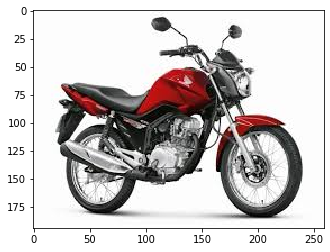

(<matplotlib.image.AxesImage at 0x14efbe10>, None)

In [30]:
img = cv.imread("moto.jpg")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.show()

Para esse caso, o buscador funcionou perfeitamente, conseguindo que as três imagens mais parecidas fossem motos.

C:/Users/jorge/Dropbox/BancoDeImagens/moto3.jpg


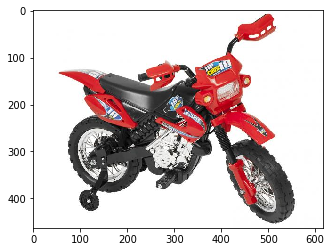

C:/Users/jorge/Dropbox/BancoDeImagens/moto.png


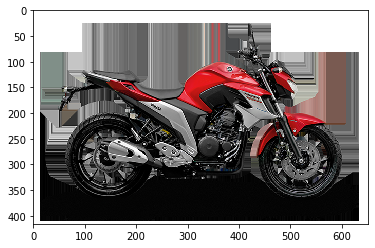

C:/Users/jorge/Dropbox/BancoDeImagens/moto6.jpg


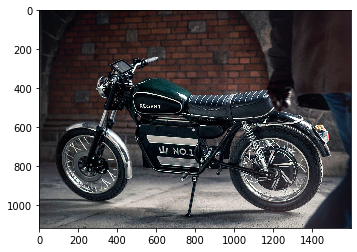

In [23]:
res1 = find_similar('moto.jpg', image_list, hist_list)

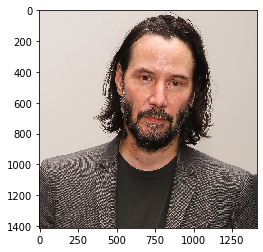

(<matplotlib.image.AxesImage at 0x14e9cf50>, None)

In [31]:
img = cv.imread("keanu_reeves.jpg")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.show()

Para esse caso, o resultado não foi tão bom quanto o esperado, sendo que uma moto está na segunda posição de imagem mais parecida com uma pessoa e nenhuma das pessoas encontradas era o Keanu Reeves, cuja foto foi utilizada para a criação do vocabulário.

C:/Users/jorge/Dropbox/BancoDeImagens/menina.jpeg


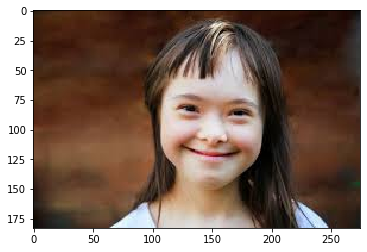

C:/Users/jorge/Dropbox/BancoDeImagens/moto6.jpg


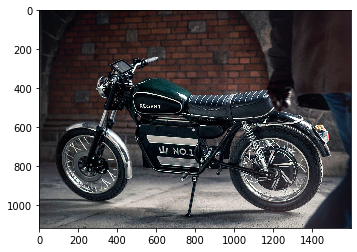

C:/Users/jorge/Dropbox/BancoDeImagens/rock.jpg


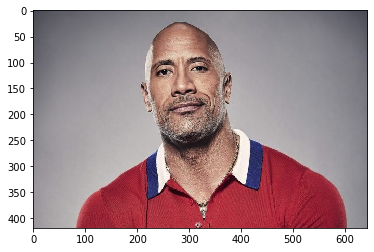

In [26]:
res2 = find_similar('keanu_reeves.jpg', image_list, hist_list)

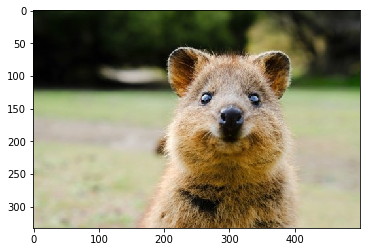

(<matplotlib.image.AxesImage at 0x16c7afb0>, None)

In [32]:
img = cv.imread("quokk.jpg")
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)), plt.show()

Já nesse último teste, as limitações do buscador ficam bem evidentes, uma vez que existem imagens de quokkas no banco, parecidas com a utilizada como base, mas nenhuma delas é encontrada nos resultados. Além disso, os resultados não apresentam nenhum padrão ou classificação que justifique eles estarem juntos.

C:/Users/jorge/Dropbox/BancoDeImagens/vrumvrum.jpg


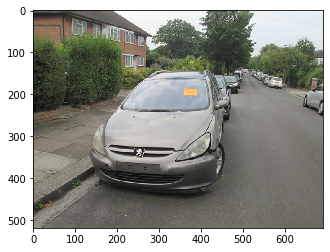

C:/Users/jorge/Dropbox/BancoDeImagens/countryside4.jpg


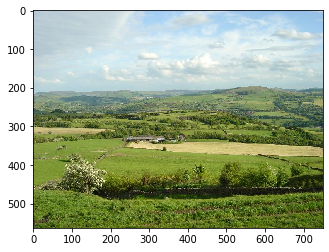

C:/Users/jorge/Dropbox/BancoDeImagens/cidade1.jpg


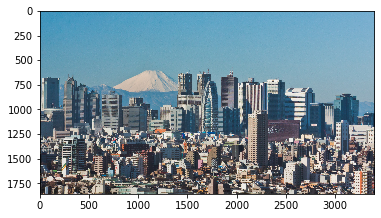

In [27]:
res3 = find_similar('quokk.jpg', image_list, hist_list)